In [1]:
import pandas as pd
import numpy as np
import gc 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
# 파일 로드
train_df = pd.read_csv('./data/train.csv')
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
weather_train_df = pd.read_csv('./data/weather_train.csv')


test_df = pd.read_csv('./data/test.csv')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')

weather_test_df = pd.read_csv('./data/weather_test.csv')
building_meta_df = pd.read_csv('./data/building_metadata.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

Wall time: 25.9 s


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [5]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = px.line(train_temp_df_meter, x='date', y='meter_reading_log1p')
    fig.show()

In [6]:
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

train_df['date'] = train_df['timestamp'].dt.date
train_df['hour'] = train_df['timestamp'].dt.hour
train_df['weekend'] = train_df['timestamp'].dt.weekday
train_df['month'] = train_df['timestamp'].dt.month
train_df['dayofweek'] = train_df['timestamp'].dt.dayofweek


test_df['date'] = test_df['timestamp'].dt.date
test_df['hour'] = test_df['timestamp'].dt.hour
test_df['weekend'] = test_df['timestamp'].dt.weekday
test_df['month'] = test_df['timestamp'].dt.month
test_df['dayofweek'] = test_df['timestamp'].dt.dayofweek

In [7]:
holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]

train_df["is_holiday"] = (train_df.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
test_df["is_holiday"] = (test_df.timestamp.dt.date.astype("str").isin(holidays)).astype(int)

In [8]:
weather_train_df.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [9]:
weather_train_df.head()
weather_train_df = weather_train_df.groupby('site_id').apply\
                    (lambda group : group.interpolate(limit_direction='both'))
weather_test_df = weather_test_df.groupby('site_id').apply\
                    (lambda group : group.interpolate(limit_direction='both'))

In [10]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [11]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)
add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

In [12]:
train_df = pd.merge(train_df,building_meta_df, on= ['building_id'],how='left')
test_df = pd.merge(test_df,building_meta_df, on= ['building_id'],how='left')

In [13]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'], format = '%Y-%m-%d %H:%M:%S')

train_df = pd.merge(train_df,weather_train_df, on= ['site_id','timestamp'],how='left')
test_df = pd.merge(test_df,weather_test_df, on= ['site_id','timestamp'],how='left')

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [15]:
le = LabelEncoder()
# train_df['primary_use'] = train_df['primary_use'].astype(str)
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

# test_df['primary_use'] = test_df['primary_use'].astype(str)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

In [16]:
train_df['age'] = train_df['year_built'].max()-train_df['year_built']+1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

In [17]:
train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16)

In [18]:
drop_cols = ['date',"precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed","timestamp"]
target = train_df["meter_reading_log1p"]
del train_df["meter_reading"], train_df['meter_reading_log1p']
train_df = train_df.drop(drop_cols, axis=1)
drop_cols += ["row_id"]
# drop_cols.remove('date')
test_df = test_df.drop(drop_cols, axis=1)

In [19]:
train_df.head()
categorical_features = ["building_id", "site_id", "meter", "hour", "weekend",'month','is_holiday','primary_use']

In [20]:
import lightgbm as lgb
from sklearn.model_selection import KFold

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse", # custom maetric로 rmsle함수를 만들어 사용했을 경우 성적이 하락한다.
    
}

In [21]:
%%time
folds = 3
seed = 99
# shuffle = False
kf = KFold(n_splits=folds, shuffle=False, random_state=seed)
scores = [] 
models = []
for train_index, val_index in kf.split(train_df):
    train_X = train_df.iloc[train_index]
    val_X = train_df.iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y,categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(val_X, val_y,categorical_feature=categorical_features)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=5000, #300,
                    valid_sets=(lgb_train, lgb_eval),
                    #feval=rmsle_lgbm,
                    early_stopping_rounds= 100,#100,
                    verbose_eval=50) #100)

    scores.append(gbm.predict(val_X))
    
    models.append(gbm)
    del gbm

C:\Users\user\anaconda3\envs\tftorch\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\user\anaconda3\envs\tftorch\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.043478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13683
[LightGBM] [Info] Number of data points in the train set: 13477400, number of used features: 72


C:\Users\user\anaconda3\envs\tftorch\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\user\anaconda3\envs\tftorch\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 4.234091
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.760795	valid_1's rmse: 1.45537
[100]	training's rmse: 0.617348	valid_1's rmse: 1.41985
[150]	training's rmse: 0.5593	valid_1's rmse: 1.40543
[200]	training's rmse: 0.528763	valid_1's rmse: 1.40116
[250]	training's rmse: 0.508038	valid_1's rmse: 1.40119
[300]	training's rmse: 0.492805	valid_1's rmse: 1.40097
[350]	training's rmse: 0.481159	valid_1's rmse: 1.40078
[400]	training's rmse: 0.471826	valid_1's rmse: 1.4008
Early stopping, best iteration is:
[347]	training's rmse: 0.481854	valid_1's rmse: 1.40072
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.635883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13781
[LightGBM] [Info] Number of data points in the train set: 13477400, number of used fea

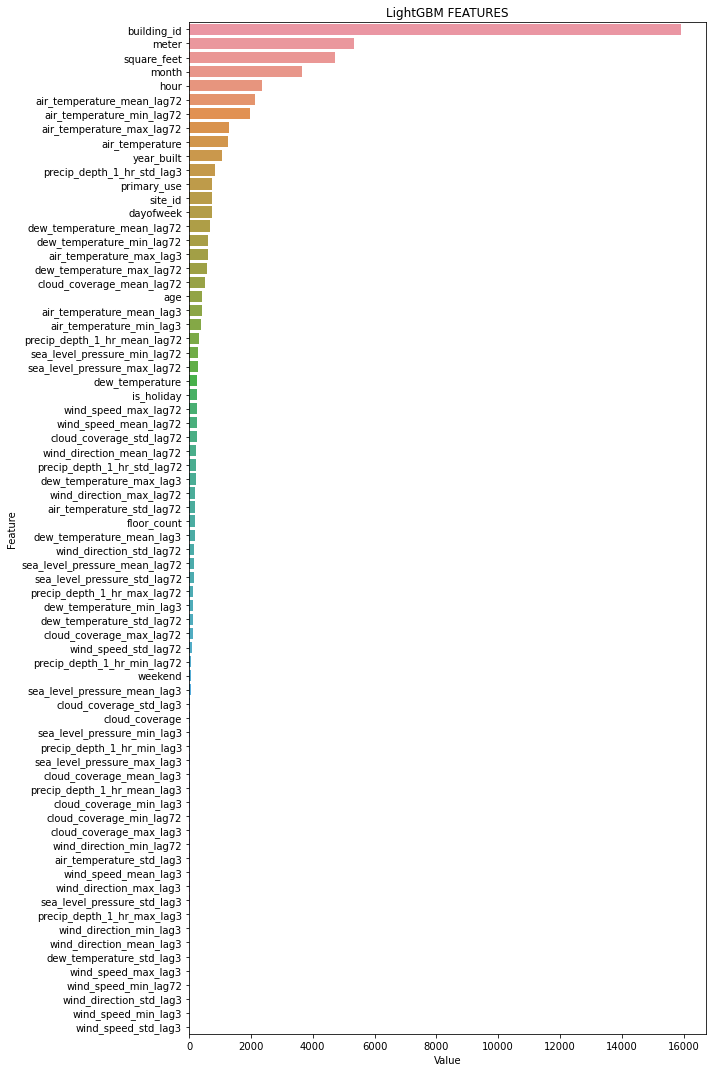

Wall time: 1.65 s


In [22]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

gbm = models[-1]
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), gbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 15))

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

In [23]:
%%time
i = 0
res = []
res2 = []
res3 = []
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0] / 50000)))):
#     # 평균을 내고 나서 exp를 취하는 코드
    res.append(np.expm1(sum([model.predict(test_df.iloc[i:i + step_size]) for model in models]) / folds))
    # exp를 취하고 평균을 내는 코드 https://www.kaggle.com/rohanrao/ashrae-half-and-half
    res2.append(sum([np.expm1(model.predict(test_df.iloc[i:i + step_size])) for model in models])/ folds)
    res3.append([np.expm1(model.predict(test_df.iloc[i:i + step_size])) for model in models])
    
    i += step_size

100%|████████████████████████████████████████████████████████████████████████████████| 834/834 [58:26<00:00,  4.20s/it]

Wall time: 58min 26s


In [24]:
%%time
from datetime import datetime

res = np.concatenate(res)
sample_submission["meter_reading"] = res
sample_submission.loc[sample_submission['meter_reading'] < 0, 'meter_reading'] = 0
sample_submission.to_csv('avg_exp_sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)
sample_submission.head(10)

Wall time: 1min 22s


,row_id,meter_reading
0,0,4.885802
1,1,2.946902
2,2,1.025360
3,3,6.531234
4,4,12.449160
5,5,1.456451
6,6,3.485541
7,7,9.424826
8,8,193.743231
9,9,6.841457


In [25]:
%%time

res2 = np.concatenate(res2)
sample_submission["meter_reading"] = res2
sample_submission.loc[sample_submission['meter_reading'] < 0, 'meter_reading'] = 0
sample_submission.to_csv('exp_avg_sub_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)
sample_submission.head(10)

Wall time: 1min 22s


,row_id,meter_reading
0,0,36.546199
1,1,13.636049
2,2,1.783069
3,3,69.628827
4,4,326.485203
5,5,2.829313
6,6,13.434383
7,7,107.398594
8,8,255.485725
9,9,62.078024
